In [1]:
%matplotlib inline


In [2]:
import numpy as np
from astropy.io import fits
import matplotlib.pyplot as plt
from lightkurve import TessLightCurveFile
from astropy.coordinates import SkyCoord
import astropy.units as u
import lightkurve

In [3]:
target = 'au mic'
tpf = lightkurve.search_targetpixelfile(target, ).download()

/home/tom/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in greater
  This is separate from the ipykernel package so we can avoid doing imports until


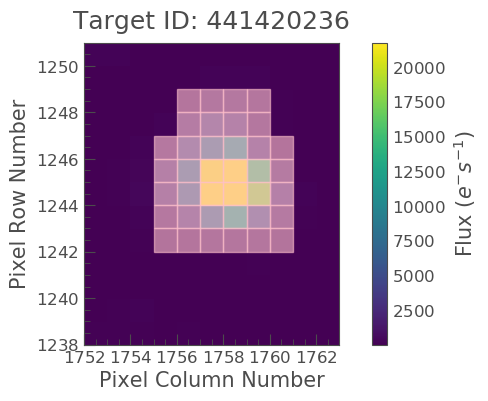

In [4]:
texp = tpf.hdu[1].header['FRAMETIM'] * tpf.hdu[1].header["NUM_FRM"]
texp /= 60.0 * 60.0 * 24.0
mask = np.isfinite(np.sum(np.sum(tpf.flux, axis=1), axis=1)) & (np.sum(np.sum(tpf.flux, axis=1), axis=1) > 0)
time = tpf.time[mask]
flux = tpf.flux[mask]

pix_mask = tpf.create_threshold_mask(threshold=2)
tpf.plot(aperture_mask=pix_mask, )

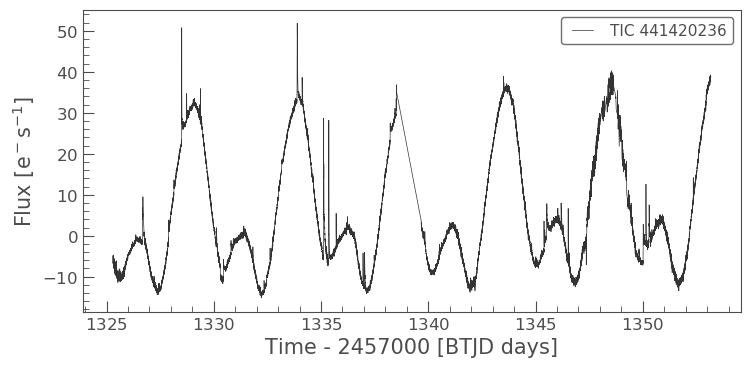

In [5]:
lc = tpf.extract_aperture_photometry(aperture_mask=pix_mask, )
lc.remove_nans()
lc = lc.normalize()
lc.flux = (lc.flux[mask] - 1.0) * 1e3
lc.time = lc.time[mask]
lc.plot(normalize=False)

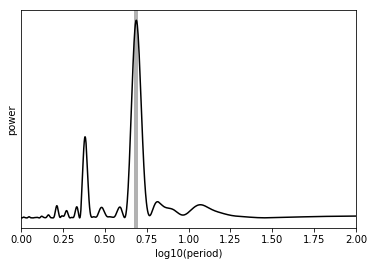

In [6]:
import exoplanet as xo

results = xo.estimators.lomb_scargle_estimator(
    lc.time, lc.flux, max_peaks=1, min_period=1.0, max_period=100.0,
    samples_per_peak=50)

peak = results["peaks"][0]
freq, power = results["periodogram"]
plt.plot(-np.log10(freq), power, "k")
plt.axvline(np.log10(peak["period"]), color="k", lw=4, alpha=0.3)
plt.xlim((-np.log10(freq)).min(), (-np.log10(freq)).max())
plt.yticks([])
plt.xlabel("log10(period)")
plt.ylabel("power");

In [46]:
x = np.ascontiguousarray(lc.time, dtype=np.float64)
y = np.ascontiguousarray(lc.flux, dtype=np.float64)
yerr = np.ascontiguousarray(np.ones_like(lc.flux) * 0.1, dtype=np.float64)

import pymc3 as pm
import theano.tensor as tt

# with pm.Model() as model:

#     # The mean flux of the time series
#     mean = pm.Normal("mean", mu=-20.0, sd=100.0)
    
#     # A jitter term describing excess white noise
#     logs2 = pm.Normal("logs2", mu=2*np.log(0.1), sd=5.0)

#     # The parameters of the RotationTerm kernel
#     logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5.0)
# #     period = pm.Bound(pm.Normal, 
# #                          lower=peak["period"]/2, 
# #                          upper=peak["period"]*2)("period", mu=peak["period"], sd=1.0)
# #     period = pm.Normal("period", mu=peak["period"], sd=1.0)
#     period = pm.Bound(pm.Normal, 
#                          lower=peak["period"]/2, 
#                          upper=100)("period", mu=peak["period"], sd=0.1)
#     logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
#     logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
#     mix = pm.Uniform("mix", lower=0.4, upper=1.0)

#     # Set up the Gaussian Process model
#     k1 = xo.gp.terms.RotationTerm(
#         log_amp=logamp,
#         period=period,
#         log_Q0=logQ0,
#         log_deltaQ=logdeltaQ,
#         mix=mix
#     )
#     kernel = k1*k1
#     gp = xo.gp.GP(kernel, x, yerr**2)

#     # Compute the Gaussian Process likelihood and add it into the
#     # the PyMC3 model as a "potential"
#     pm.Potential("loglike", gp.log_likelihood(y - mean + tt.exp(logs2)))

#     # Compute the mean model prediction for plotting purposes
#     pm.Deterministic("pred", gp.predict())

#     # Optimize to find the maximum a posteriori parameters
#     map_soln = pm.find_MAP(start=model.test_point)

In [127]:
def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones_like(x, dtype=bool)
    p_period = 16.93
    p_t0 = 1330.3875
    p_depth = 0.001
    with pm.Model() as model:

        # The mean flux of the time series
        mean = pm.Normal("mean", mu=0.0, sd=10.0)

        # A jitter term describing excess white noise
        logs2 = pm.Normal("logs2", mu=2*np.log(np.min(yerr[mask])/5), sd=1.0)

        # A SHO term to capture long term trends
        logS = pm.Normal("logS", mu=0.0, sd=15.0, testval=np.log(np.var(y[mask])))
        logw = pm.Normal("logw", mu=np.log(2*np.pi/10.0), sd=10.0)
        term1 = xo.gp.terms.SHOTerm(log_S0=logS, log_w0=logw, Q=1/np.sqrt(2))

        # The parameters of the RotationTerm kernel
        logamp = pm.Normal("logamp", mu=np.log(np.var(y[mask])), sd=5.0)
        period = pm.Bound(pm.Normal, 
                         lower=peak["period"]/2, 
                         upper=100)("period", mu=peak["period"], sd=0.1)
        logQ0 = pm.Normal("logQ0", mu=1.0, sd=10.0)
        logdeltaQ = pm.Normal("logdeltaQ", mu=2.0, sd=10.0)
        mix = pm.Uniform("mix", lower=0, upper=1.0)
        term2 = xo.gp.terms.RotationTerm(
            log_amp=logamp,
            period=period,
            log_Q0=logQ0,
            log_deltaQ=logdeltaQ,
            mix=mix
        )

        u_star = xo.distributions.QuadLimbDark("u_star",
                                              testval=np.array([0.3, 0.2]))
        R_star = 0.291, 0.025
        Rho_star = 18.0, 2.0
        r_star = pm.Normal("r_star", mu=R_star[0], sd=R_star[1])
        rho_star = pm.Normal("rho_star", mu=Rho_star[0], sd=Rho_star[1])
        pm.Potential("r_star_prior", tt.switch(r_star > 0, 0, -np.inf))
        logP = pm.Normal("logP", mu=np.log(p_period), sd=1)
        t0 = pm.Normal("t0", mu=p_t0, sd=0.1)
        ror, b = xo.distributions.get_joint_radius_impact(
            min_radius=0.005, max_radius=0.3,
            testval_r=0.04,
            testval_b=0.1)
#         ecc = pm.Bound(pm.Beta, lower=0.0, upper=1.0)("ecc", alpha=0.867, beta=3.03, testval=0.01)
#         omega = xo.distributions.Angle("omega")
        pm.Potential("ror_prior", -tt.log(ror))
        pm.Potential("b_prior",  tt.switch(b < 1, 0, -np.inf))
        p_period = pm.Deterministic("p_period", tt.exp(logP))
        r_pl = pm.Deterministic("r_pl", r_star * ror)
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star, #m_star=m_star,
            period=p_period, t0=t0, b=b,
            ecc=0, omega=0,
            rho_star=rho_star)
        light_curves = xo.StarryLightCurve(u_star, r_star=r_star).get_light_curve(
            orbit=orbit, r=r_pl, t=x[mask], texp=texp)*1e3
        light_curve = pm.math.sum(light_curves, axis=-1)
        pm.Deterministic("light_curves", light_curve)
        

        
        # Set up the Gaussian Process model
        kernel = term1 + term2
        gp = xo.gp.GP(kernel, x[mask], yerr[mask]**2 + tt.exp(logs2), J=6)

        # Compute the Gaussian Process likelihood and add it into the
        # the PyMC3 model as a "potential"
        pm.Potential("loglike", gp.log_likelihood(y[mask] - mean - light_curve))

        # Compute the mean model prediction for plotting purposes
        pm.Deterministic("pred", gp.predict())

        # Optimize to find the maximum a posteriori parameters
        if start is None:
            start = model.test_point
        map_soln = pm.find_MAP(start=start, vars=[mean, logs2])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logS, logw])
        map_soln = pm.find_MAP(start=map_soln, vars=[mean, logs2, logamp, logQ0, logdeltaQ, mix])
        map_soln = pm.find_MAP(start=map_soln, vars=[u_star, ror])

    return model, map_soln

mask = np.ones_like(y, dtype=bool)
map_soln0 = None
logp = -np.inf
while True:
    model0, map_soln0 = build_model(mask=mask, start=map_soln0)
    mod = map_soln0["pred"] + map_soln0["mean"]
    resid = y[mask] - mod
    rms = np.sqrt(np.median(resid**2))
    if model0.logp(map_soln0) < logp+3:
        break
    else:
        break
    logp = model0.logp(map_soln0)
    mask[mask] = mask[mask] & (resid < 3 * rms)
    print()


/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
logp = -1.4117e+05, ||grad|| = 5,325.5: 100%|██████████| 20/20 [00:00<00:00, 38.60it/s]  
logp = -1.2797e+05, ||grad|| = 0.20207: 100%|██████████| 22/22 [00:00<00:00, 28.74it/s]  
logp = -1.279e+05, ||grad|| = 219.53: 100%|██████████| 25/25 [00:00<00:00, 29.37it/s]  
  0%|          | 0/5000 [00:00<?, ?it/s]/home/tom/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, whi

In [128]:
map_soln0

{'mean': array(0.10059291),
 'logs2': array(-1.40716916),
 'logS': array(2.3200447),
 'logw': array(3.30458666),
 'logamp': array(3.39555635),
 'period_interval__': array(0.),
 'logQ0': array(-5.14619017),
 'logdeltaQ': array(1.95110365),
 'mix_interval__': array(0.70762428),
 'u_star_quadlimbdark__': array([-11.20955988,   0.12364148]),
 'r_star': array(0.291),
 'rho_star': array(18.),
 'logP': array(2.8290872),
 't0': array(1330.3875),
 'rb_radiusimpact__': array([[ -0.05436214],
        [-14.2233542 ]]),
 'period': array(51.21772795),
 'mix': array(0.669876),
 'u_star': array([ 0.00390743, -0.00022722]),
 'rb': array([[0.0050002 ],
        [0.41309076]]),
 'r': array([0.0050002]),
 'b': array([0.41309076]),
 'p_period': array(16.93),
 'r_pl': array([0.00145506]),
 'light_curves': array([0., 0., 0., ..., 0., 0., 0.]),
 'pred': array([-5.69726407, -5.91012757, -6.07860338, ..., 38.69173626,
        38.69445579, 38.6656445 ])}

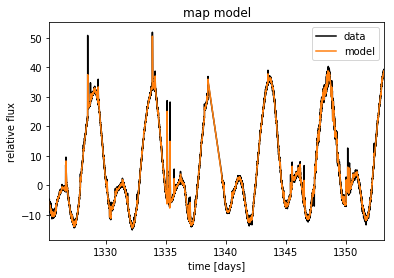

In [123]:
plt.plot(x, y, "k", label="data")
plt.plot(x[mask], map_soln0["pred"] + map_soln0["mean"], color="C1", label="model")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");

(1329.4, 1331.4)

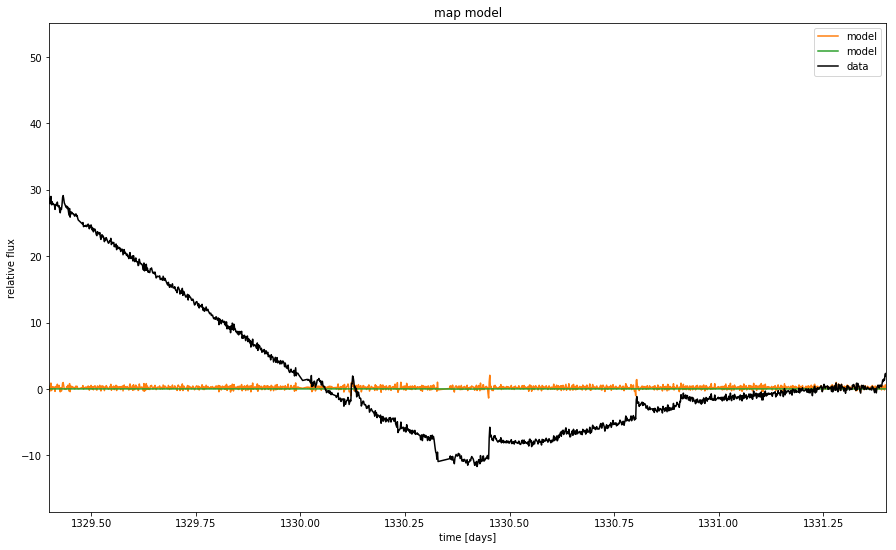

In [126]:

fig, ax = plt.subplots(1,1, figsize=[15,9])
plt.plot(x[mask], y[mask] - map_soln0["pred"] + map_soln0["mean"], color="C1", label="model")
plt.plot(x[mask], map_soln0["light_curves"], color="C2", label="model")
plt.plot(x, y, "k", label="data")
plt.xlim(x.min(), x.max())
plt.legend(fontsize=10)
plt.xlabel("time [days]")
plt.ylabel("relative flux")
plt.title("map model");
plt.xlim(1330.4 + (16.93*0)-1, 1330.4 + (16.93*0)+1)

In [114]:
((450-325) / 2)+ 325

387.5

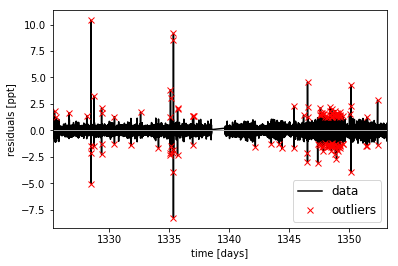

In [167]:
mod = map_soln0["pred"] + map_soln0["mean"]
resid = y - mod
rms = np.sqrt(np.median(resid**2))
mask = np.abs(resid) < 7 * rms

plt.plot(x, resid, "k", label="data")
plt.plot(x[~mask], resid[~mask], "xr", label="outliers")
plt.axhline(0, color="#aaaaaa", lw=1)
plt.ylabel("residuals [ppt]")
plt.xlabel("time [days]")
plt.legend(fontsize=12, loc=4)
plt.xlim(x.min(), x.max());

In [8]:
np.sqrt(1.E-3)

0.03162277660168379